### Initial Implementation

##### 1. Imports

In [1]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 11.7 MB/s eta 0:00:00


In [2]:
from huggingface_hub import login
from google.colab import userdata
from datasets import load_dataset

import re
import emoji
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import SpatialDropout1D, Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Input

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

##### 2. Load Dataset

In [3]:
# load dataset.
login(userdata.get('HF_TOKEN'))
data = load_dataset("shainar/BEAD", "Full_Annotations", split="full")
print(data)

README.md:   0%|          | 0.00/7.08k [00:00<?, ?B/s]

Full.csv:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text', 'dimension', 'biased_words', 'aspect', 'label', 'sentiment', 'toxic', 'identity_mention'],
    num_rows: 3674927
})


In [4]:
# convert to pandas dataframe.
df = data.to_pandas()
df = df.rename(columns={"label": "bias"})
print(df.head())

                                                text             dimension  \
0  Where will this leave the kids??? That my frie...  Ageism and sentiment   
1   I had a feeling of impending doom &amp; then ...  Ageism and sentiment   
2                                 I no feel good ..   Ageism and sentiment   
3  Back in Hotlanta for a about a week, then off ...  Ageism and sentiment   
4  Kids toys &amp; stamping stuff cleaned up... N...  Ageism and sentiment   

            biased_words          aspect             bias sentiment  toxic  \
0                     []     Transphobia  Slightly Biased  Negative    0.0   
1  ['impending', 'doom']  Climate change    Highly Biased  Negative    1.0   
2                     []    Body-shaming          Neutral  Positive    0.0   
3                     []       Lifestyle  Slightly Biased  Negative    0.0   
4                     []           Hobby          Neutral   Neutral    1.0   

  identity_mention  
0               NO  
1               NO  

In [5]:
# collect approx. 25% of dataset.
df = df.drop(['dimension', 'aspect', 'identity_mention'], axis=1)
df = df.sample(n=900000, random_state=42, replace=False)
print(df.shape)

(900000, 5)


##### 3. Text Pre-processing

In [6]:
# number of empty data items by attribute.
print(df.isnull().sum())

text            1
biased_words    0
bias            0
sentiment       0
toxic           0
dtype: int64


In [7]:
# drop blank texts.
before = len(df)
df = df.dropna(subset=['text'])
after = len(df)
print(f"Dropped {before - after} rows.")

Dropped 1 rows.


In [8]:
# drop duplicate rows.
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"Dropped {before - after} rows.")

Dropped 10 rows.


In [9]:
# convert text to 'string'.
df['text'] = df['text'].astype(str)

In [10]:
# clean text.
text = df['text']
text = text.apply(lambda x: x.lower())

def edit(text):
	text = emoji.demojize(text).replace(":", "").replace("_", " ")                # convert emojis to words
	text = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', text)   # remove HTML tags and entities
	text = re.sub(r'https?://\S+|www\.\S+', '', text)                             # remove URLs
	text = re.sub(r'[^a-z0-9\s.,!?]', '', text)                                   # remove special characters
	text = re.sub(r'\s+', ' ', text).strip()                                      # collapse spaces
	return text

text = text.apply(edit)
df['text'] = text

In [11]:
# find range of text lengths.
df["text_length"] = df["text"].str.len()
desc = df["text_length"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(desc)

count    899989.000000
mean        204.322927
std         280.743742
min           0.000000
25%          56.000000
50%         105.000000
75%         234.000000
90%         530.000000
95%         792.000000
99%         989.000000
max       23171.000000
Name: text_length, dtype: float64


In [12]:
# print record with longest text.
ind = df["text_length"].idxmax()
row = df.loc[ind]
print(row)

text            internet censorship is hurting conservative we...
biased_words    ['subjected', 'gore', 'infected', 'unreliable'...
bias                                                Highly Biased
sentiment                                                Negative
toxic                                                         0.0
text_length                                                 23171
Name: 2316867, dtype: object


In [13]:
# drop texts with length < 10.
min_len = 10
ind_drop = df[df['text'].str.len() < min_len].index
print(f"Dropped {len(ind_drop)} rows.")
df.drop(ind_drop, inplace=True)

Dropped 2904 rows.


In [14]:
# drop texts with length > 512.
max_len = 512
ind_drop = df[df['text'].str.len() > max_len].index
print(f"Dropped {len(ind_drop)} rows.")
df.drop(ind_drop, inplace=True)

Dropped 94605 rows.


##### 4. Dataset Characteristics

In [15]:
# number of rows.
print(f"{len(df)} rows.")

802480 rows.


In [16]:
# processed text length range.
desc = df["text_length"].describe()
print(desc)

count    802480.000000
mean        130.287124
std         111.524035
min          10.000000
25%          53.000000
50%          93.000000
75%         160.000000
max         512.000000
Name: text_length, dtype: float64


In [17]:
# class distribution of 'bias'.
print(df['bias'].value_counts())

bias
Neutral            447448
Slightly Biased    225694
Highly Biased      129338
Name: count, dtype: int64


In [18]:
# class distribution of 'sentiment'.
print(df['sentiment'].value_counts())

sentiment
Positive    360324
Negative    257068
Neutral     185088
Name: count, dtype: int64


In [19]:
# class distribution of 'toxic'.
print(df['toxic'].value_counts())

toxic
0.0    525357
1.0    277123
Name: count, dtype: int64


##### 5. Encoding Categorical Columns

In [20]:
# encode categorical columns.
y = pd.DataFrame(data)
target_columns = ['bias', 'sentiment', 'toxic']

encoders = {}
for col in target_columns:
  encoder = LabelEncoder()
  df[col] = encoder.fit_transform(df[col])
  encoders[col] = encoder
  print("Mapping:", dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

Mapping: {'Highly Biased': np.int64(0), 'Neutral': np.int64(1), 'Slightly Biased': np.int64(2)}
Mapping: {'Negative': np.int64(0), 'Neutral': np.int64(1), 'Positive': np.int64(2)}
Mapping: {np.float64(0.0): np.int64(0), np.float64(1.0): np.int64(1)}


In [21]:
# print encoded dataset.
print(df.head())

                                                      text  \
3102936  sorry but i remember all the denial about wate...   
1130     lizzie mendez you having a down day? just had ...   
1787497           but i know its going to hurt pretty bad.   
1688066  kind of interesting 1st day 12 of around us wa...   
1109220  so what does that have to do with the small bu...   

                  biased_words  bias  sentiment  toxic  text_length  
3102936             ['denial']     2          1      0           66  
1130     ['rocky', 'sinfully']     2          1      0           88  
1787497                     []     2          0      0           40  
1688066                     []     1          2      0          123  
1109220                     []     1          2      0          412  


##### 6. Tokenisation & Padding

In [22]:
# tokenize and pad text for deep learning.
MAX_VOCAB = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])

X = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')

##### 7. Train-Test Split

In [23]:
# target labels.
y = df[['bias', 'sentiment', 'toxic']]
print(y)

         bias  sentiment  toxic
3102936     2          1      0
1130        2          1      0
1787497     2          0      0
1688066     1          2      0
1109220     1          2      0
...       ...        ...    ...
82889       2          2      0
233613      1          2      0
2561393     0          0      1
52428       1          2      1
1067302     1          1      1

[802480 rows x 3 columns]


In [24]:
# split for training, testing and validation as 80%-10%-10%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [25]:
# convert to numpy.
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_valid:", X_valid.shape)

y_train_bias = y_train["bias"].to_numpy()
y_train_sentiment = y_train["sentiment"].to_numpy()
y_train_toxic = y_train["toxic"].to_numpy()

y_test_bias = y_test["bias"].to_numpy()
y_test_sentiment = y_test["sentiment"].to_numpy()
y_test_toxic = y_test["toxic"].to_numpy()

y_valid_bias = y_valid["bias"].to_numpy()
y_valid_sentiment = y_valid["sentiment"].to_numpy()
y_valid_toxic = y_valid["toxic"].to_numpy()

X_train: (641984, 100)
X_test: (80248, 100)
X_valid: (80248, 100)


##### 8. Model Architecture

In [26]:
# neutrosophic loss function.
def neutrosophic_loss(alpha=1.0, beta=0.5, gamma=0.5, num_classes=None):
    def loss_fn(y_true, y_pred):
        # apply softmax to convert logits to probabilities
        y_pred = tf.nn.softmax(y_pred, axis=-1)

        # clip softmax probabilities
        y_pred = K.clip(y_pred, 1e-7, 1.0)

        # convert sparse labels to one-hot
        y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)

        # T (probability of the correct class)
        T = K.sum(y_true_onehot * y_pred, axis=-1)

        # F (probability mass on wrong classes)
        F = 1.0 - T

        # I (normalized shannon entropy)
        entropy = -K.sum(y_pred * K.log(y_pred), axis=-1)
        max_entropy = K.log(tf.cast(num_classes, K.floatx()))
        I = entropy / max_entropy

        # final loss function
        loss = -alpha * K.log(T) + beta * F + gamma * I
        return loss
    return loss_fn

In [28]:
embedding_dim = 128

# input layer
input_layer = Input(shape=(X_train.shape[1],))

# hidden layers
x = Embedding(input_dim=MAX_VOCAB, output_dim=embedding_dim)(input_layer)
x = SpatialDropout1D(0.2)(x)

x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.2))(x)

x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# output layers
output_bias = Dense(len(encoders['bias'].classes_), activation='linear', name="output_b")(x)
output_sentiment = Dense(len(encoders['sentiment'].classes_), activation='linear', name="output_s")(x)
output_toxic = Dense(len(encoders['toxic'].classes_), activation='linear', name="output_t")(x)

model = Model(inputs=input_layer, outputs=[output_bias, output_sentiment, output_toxic])

# learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# compile model
model.compile(
    optimizer=optimizer,
    loss={
        "output_b": neutrosophic_loss(num_classes=len(encoders['bias'].classes_)),
        "output_s": neutrosophic_loss(num_classes=len(encoders['sentiment'].classes_)),
        "output_t": neutrosophic_loss(num_classes=len(encoders['toxic'].classes_))
    },
    metrics={
        "output_b": "accuracy",
        "output_s": "accuracy",
        "output_t": "accuracy"
    }
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 100, 128)  │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     98,816 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_b (Dense)    │ (None, 3)         │        195 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_s (Dense)    │ (None, 3)         │        195 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_t (Dense)    │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,387,848 (5.29 MB)

 Trainable params: 1,387,720 (5.29 MB)

 Non-trainable params: 128 (512.00 B)

##### 9. Model Training

In [29]:
# train model.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train,
    {
        "output_b": y_train_bias,
        "output_s": y_train_sentiment,
        "output_t": y_train_toxic
    },
    validation_data=(
        X_valid,
        {
            "output_b": y_valid_bias,
            "output_s": y_valid_sentiment,
            "output_t": y_valid_toxic
        }
    ),
    epochs=15,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/15
20062/20062 ━━━━━━━━━━━━━━━━━━━━ 385s 19ms/step - loss: 2.8706 - output_b_accuracy: 0.7395 - output_b_loss: 1.0231 - output_s_accuracy: 0.7942 - output_s_loss: 0.8762 - output_t_accuracy: 0.7561 - output_t_loss: 0.9631 - val_loss: 1.7894 - val_output_b_accuracy: 0.8593 - val_output_b_loss: 0.6278 - val_output_s_accuracy: 0.9101 - val_output_s_loss: 0.4566 - val_output_t_accuracy: 0.8305 - val_output_t_loss: 0.6974
Epoch 2/15
20062/20062 ━━━━━━━━━━━━━━━━━━━━ 378s 19ms/step - loss: 1.9370 - output_b_accuracy: 0.8522 - output_b_loss: 0.6816 - output_s_accuracy: 0.9066 - output_s_loss: 0.5069 - output_t_accuracy: 0.8266 - output_t_loss: 0.7408 - val_loss: 1.7335 - val_output_b_accuracy: 0.8619 - val_output_b_loss: 0.6026 - val_output_s_accuracy: 0.9115 - val_output_s_loss: 0.4530 - val_output_t_accuracy: 0.8386 - val_output_t_loss: 0.6705
Epoch 3/15
20062/20062 ━━━━━━━━━━━━━━━━━━━━ 382s 19ms/step - loss: 1.8303 - output_b_accuracy: 0.8614 - output_b_loss: 0.6394 - output_s_accur

##### 10. Model Evaluation

In [30]:
# evaluate model.
y_pred_probs = model.predict(X_test)

y_pred_bias = np.argmax(y_pred_probs[0], axis=1)
y_pred_sentiment = np.argmax(y_pred_probs[1], axis=1)
y_pred_toxic = np.argmax(y_pred_probs[2], axis=1)

print("====================== Bias Task ======================")
print("Accuracy:", accuracy_score(y_test_bias, y_pred_bias))
print(classification_report(y_test_bias, y_pred_bias, target_names=encoders["bias"].classes_))

print("\n==================== Sentiment Task ====================")
print("Accuracy:", accuracy_score(y_test_sentiment, y_pred_sentiment))
print(classification_report(y_test_sentiment, y_pred_sentiment, target_names=encoders["sentiment"].classes_))

print("\n====================== Toxic Task ======================")
print("Accuracy:", accuracy_score(y_test_toxic, y_pred_toxic))
print(classification_report(y_test_toxic, y_pred_toxic, target_names=[str(cls) for cls in encoders["toxic"].classes_]))

2508/2508 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step
====================== Bias Task ======================
Accuracy: 0.8711245140065796
                 precision    recall  f1-score   support

  Highly Biased       0.83      0.79      0.81     12934
        Neutral       0.91      0.95      0.93     44745
Slightly Biased       0.80      0.76      0.78     22569

       accuracy                           0.87     80248
      macro avg       0.85      0.83      0.84     80248
   weighted avg       0.87      0.87      0.87     80248


==================== Sentiment Task ====================
Accuracy: 0.9185649486591566
              precision    recall  f1-score   support

    Negative       0.90      0.91      0.91     25707
     Neutral       0.94      0.87      0.90     18508
    Positive       0.92      0.95      0.93     36033

    accuracy                           0.92     80248
   macro avg       0.92      0.91      0.91     80248
weighted avg       0.92      0.92      0.92     80248




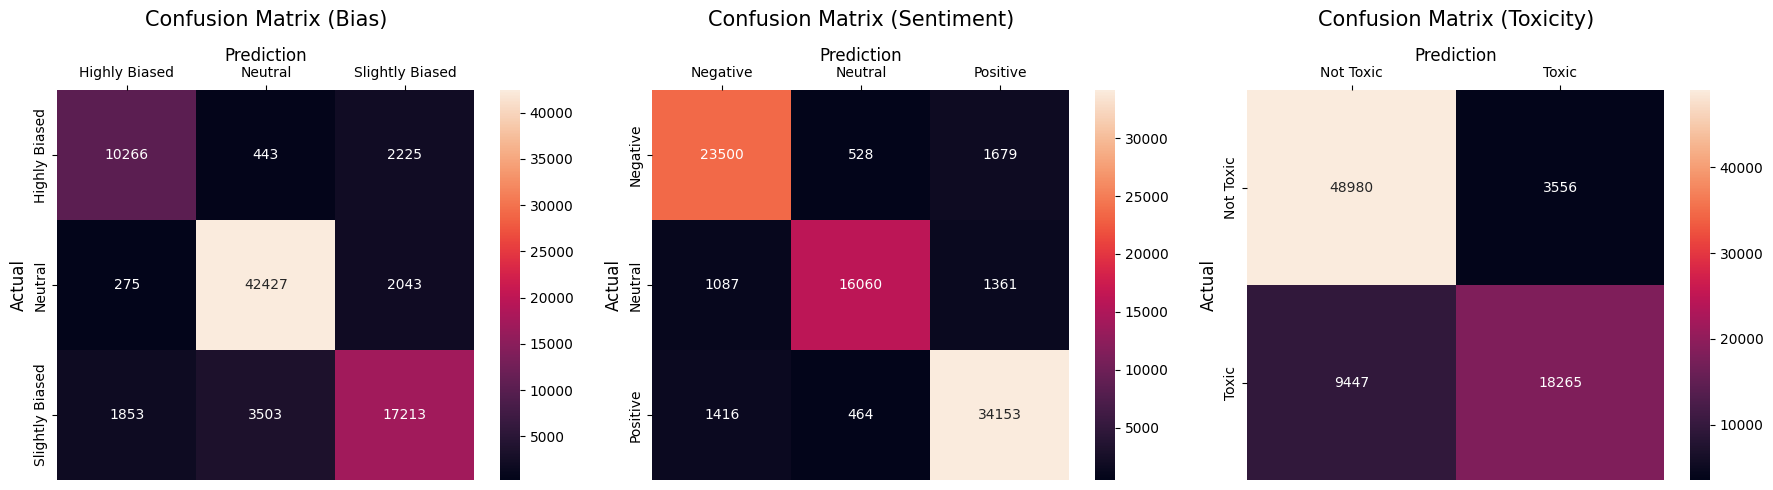

In [31]:
# confusion matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# bias
cm_bias = confusion_matrix(y_test_bias, y_pred_bias)
sns.heatmap(cm_bias, annot=True, fmt='g', xticklabels=['Highly Biased', 'Neutral','Slightly Biased'], yticklabels=['Highly Biased', 'Neutral','Slightly Biased'], ax=axes[0])
axes[0].set_title('Confusion Matrix (Bias)', fontsize=15, pad=15)
axes[0].set_xlabel('Prediction', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].xaxis.set_label_position('top')
axes[0].xaxis.tick_top()

# sentiment
cm_sentiment = confusion_matrix(y_test_sentiment, y_pred_sentiment)
sns.heatmap(cm_sentiment, annot=True, fmt='g', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'], ax=axes[1])
axes[1].set_title('Confusion Matrix (Sentiment)', fontsize=15, pad=15)
axes[1].set_xlabel('Prediction', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].xaxis.set_label_position('top')
axes[1].xaxis.tick_top()

# toxicity
cm_toxic = confusion_matrix(y_test_toxic, y_pred_toxic)
sns.heatmap(cm_toxic, annot=True, fmt='g', xticklabels=['Not Toxic', 'Toxic'], yticklabels=['Not Toxic', 'Toxic'], ax=axes[2])
axes[2].set_title('Confusion Matrix (Toxicity)', fontsize=15, pad=15)
axes[2].set_xlabel('Prediction', fontsize=12)
axes[2].set_ylabel('Actual', fontsize=12)
axes[2].xaxis.set_label_position('top')
axes[2].xaxis.tick_top()

plt.tight_layout()
plt.show()

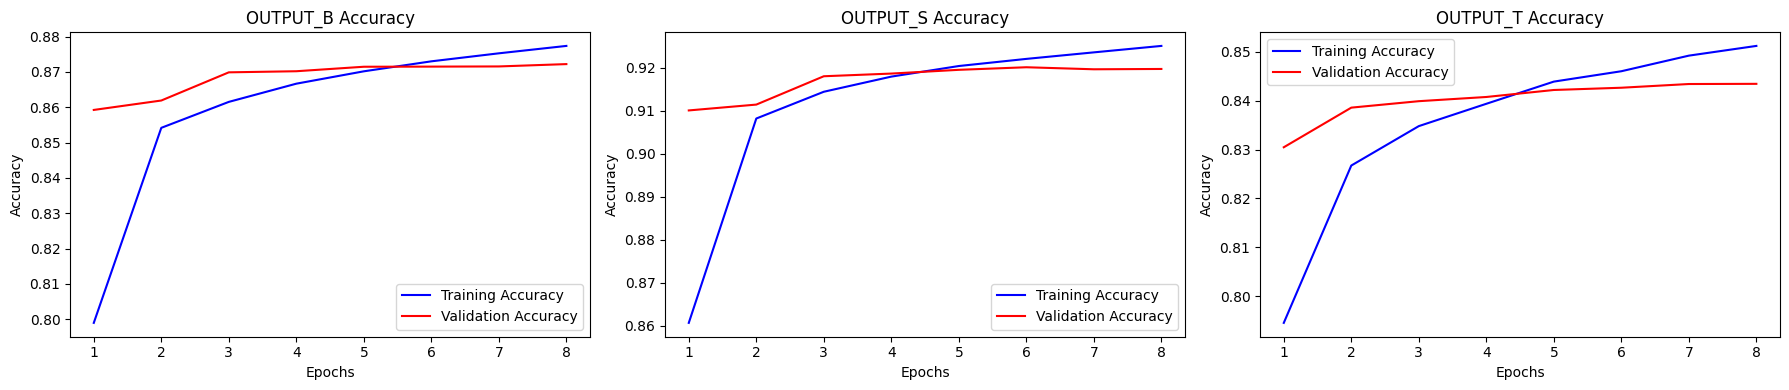

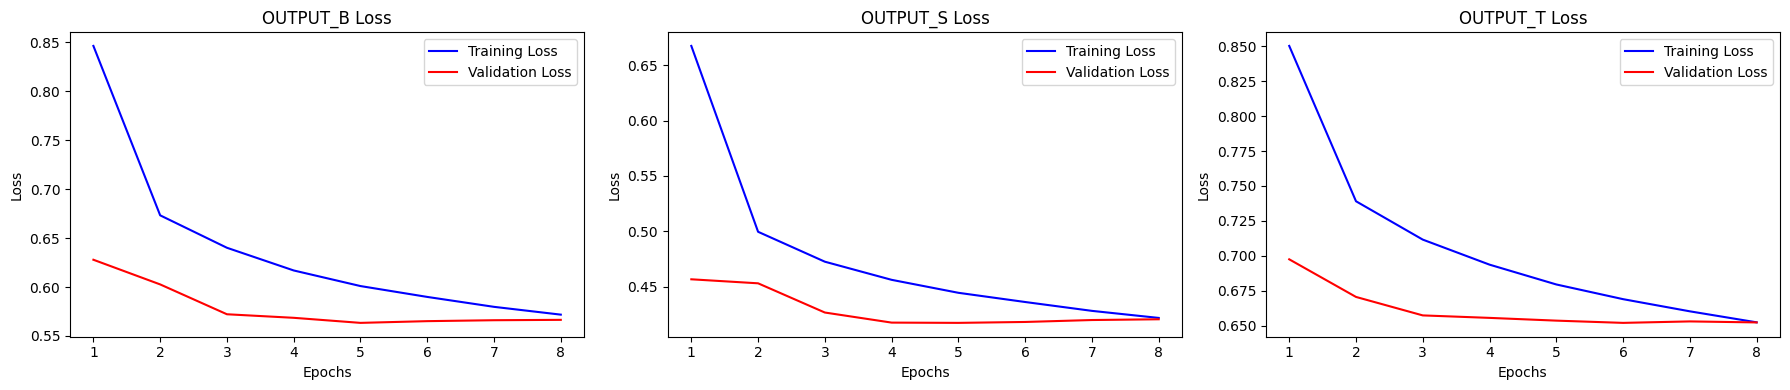

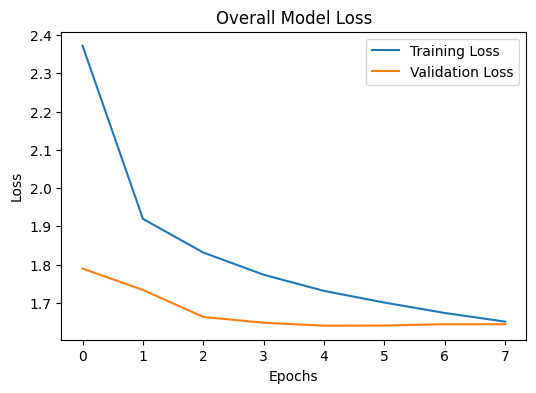

In [32]:
def plot_output(history, outputs, metric="accuracy"):
    epochs = range(1, len(history.history[f"{outputs[0]}_loss"]) + 1)

    # accuracy plot
    fig, axes = plt.subplots(1, len(outputs), figsize=(18, 4))
    for i, output in enumerate(outputs):
        train_metric = history.history[f"{output}_{metric}"]
        val_metric = history.history[f"val_{output}_{metric}"]

        axes[i].plot(epochs, train_metric, "b", label=f"Training {metric.title()}")
        axes[i].plot(epochs, val_metric, "r", label=f"Validation {metric.title()}")
        axes[i].set_title(f"{output.upper()} {metric.title()}")
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel(metric.title())
        axes[i].legend()
    plt.tight_layout()
    plt.show()

    # loss plot
    fig, axes = plt.subplots(1, len(outputs), figsize=(18, 4))
    for i, output in enumerate(outputs):
        train_loss = history.history[f"{output}_loss"]
        val_loss = history.history[f"val_{output}_loss"]

        axes[i].plot(epochs, train_loss, "b", label="Training Loss")
        axes[i].plot(epochs, val_loss, "r", label="Validation Loss")
        axes[i].set_title(f"{output.upper()} Loss")
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel("Loss")
        axes[i].legend()
    plt.tight_layout()
    plt.show()

    # overall loss
    plt.figure(figsize=(6,4))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Overall Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

outputs = ["output_b", "output_s", "output_t"]
plot_output(history, outputs, metric="accuracy")